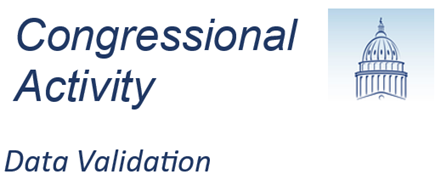

***  
# Introduction  
Since 1947, a summary of each Congressional session has been included in the Congressional Record, under the title Resume of Congressional Activity. The resume includes statistics on the number of measures introduced, bills passed, outcome of confirmations, etc.

The objective of this project is to create a dataset from published Resumes of Congressional Activity for analysis.

For this project, Resumes of Congressional Activity were downloaded in PDF form from <a href="https://www.senate.gov/">Senate.gov</a> and <a href="https://govinfo.gov">GovInfo.com</a>. Resumes from the 98th though 117th Congresses are included in this porject.

Additional information regarding the Resume of Congressional activity can be found at <a href="https://www.congress.gov/help/congressional-record">congress.gov</a>.

***
# Notebook Setup
***

In [1]:
# Import libraries
import pandas as pd
import re

In [2]:
# This notebook requires openpyxl. If you do not have this installed, uncomment the following install command
#!pip install openpyxl

***  
# Read Scrubbed Activity Data
***

In [3]:
# Read in all worksheets, dividing the data into general legislative activity and confirmation related activity
file_name = '../Data/Resume Data - Scrubbed.xlsx'
gen_activity_df = pd.read_excel(file_name, sheet_name='General Activity')
confirm_df = pd.read_excel(file_name, sheet_name='Confirmations')

***
# General Activity
***

In [4]:
# Preview the general activity dataframe
gen_activity_df.head()

,Year,Congress,Session,Chamber,Bills not signed,Bills through conference,Bills vetoed,Conference reports,Extension of remarks,Pages of proceedings,...,"Measures reported, Senate joint resolutions","Measures reported, Simple resolutions",Private bills enacted into law,Public bills enacted into law,Quorum calls,Recorded votes,Special reports,Time in session,Vetoes overridden,Yea-and-nay votes
0,1983,98,1,Senate,0,4,3,4,0,17224,...,87,139,0,101,18,0,25,1010,1,381
1,1984,98,2,Senate,0,22,8,0,0,14650,...,99,122,17,166,19,0,11,940,1,292
2,1985,99,1,Senate,0,8,0,2,0,18418,...,118,100,0,110,20,0,18,1252,1,381
3,1986,99,2,Senate,0,0,4,0,0,17426,...,111,63,7,187,16,0,15,1278,1,359
4,1987,100,1,Senate,0,0,1,1,0,18660,...,72,62,2,96,36,0,28,1214,2,420


***

In [5]:
# Test: The Years column should start with 1983 and end with 2022
print(f"Year Min: {gen_activity_df['Year'].min()}")
print(f"Year Max: {gen_activity_df['Year'].max()}")

Year Min: 1983
Year Max: 2022


***  

In [6]:
# Test: The Congress column should start with 98 and end with 117
print(f"Congress Min: {gen_activity_df['Congress'].min()}")
print(f"Congress Max: {gen_activity_df['Congress'].max()}")

Congress Min: 98
Congress Max: 117


***

In [7]:
#Test: Values for the Session column must be 1 or 2
print(f"Unique Session Values: {gen_activity_df['Session'].unique()}")

Unique Session Values: [1 2]


***

In [8]:
# Test: Values for the Chamber column must be Senate, House or Both
print(f"Unique Chamber Values: {gen_activity_df['Chamber'].unique()}")

Unique Chamber Values: ['Senate' 'House' 'Both']


***

In [9]:
# Values for Days in Session cannot exceed 365 for the Senate and House, or 730 for Both
gen_activity_df.groupby(['Chamber'])['Days in session'].max()

Chamber
Both        0
House     193
Senate    211
Name: Days in session, dtype: int64

***

In [10]:
# Test: Time in Session divided by Days in Session cannot exceed 24
temp_df = gen_activity_df.loc[gen_activity_df['Days in session'] > 0].copy()
temp_df['Avg Hours Per Day'] = (temp_df['Time in session'] / temp_df['Days in session']).astype(int)
print(f"Average Hours Per Day, Max: {temp_df['Avg Hours Per Day'].max()}")

Average Hours Per Day, Max: 9


***

In [11]:
#Test: If the Pages of Proceeding for Both chambers is not zero, then it should equal the sum of the values for the House and Senate
failures = False

for yr in gen_activity_df['Year'].unique():
    yr_rows = gen_activity_df[gen_activity_df['Year'] == yr]
    house_pgs = yr_rows[yr_rows['Chamber'] == 'House']['Pages of proceedings'].item()
    senate_pgs = yr_rows[yr_rows['Chamber'] == 'Senate']['Pages of proceedings'].item()
    both_pgs = yr_rows[yr_rows['Chamber'] == 'Both']['Pages of proceedings'].item()
    if both_pgs > 0 and house_pgs + senate_pgs != both_pgs:
        print(f'Validation Error: {yr}')
        failures = True
        
if failures == False:
    print('No validations errors found.')

Validation Error: 1984
Validation Error: 1993


<font color='red'>**Failed:**</font>  The original data sources show a miscalculation for both 1984 and 1993. Further research is needed to determine if a correction was issued, or if the values can be verified from another source.

***

In [12]:
#Test: If the Extensions of Remarks for Both chambers is not zero, then it should equal the sum of the values for the House and Senate
failures = False

for yr in gen_activity_df['Year'].unique():
    yr_rows = gen_activity_df[gen_activity_df['Year'] == yr]
    house_remarks = yr_rows[yr_rows['Chamber'] == 'House']['Extension of remarks'].item()
    senate_remarks = yr_rows[yr_rows['Chamber'] == 'Senate']['Extension of remarks'].item()
    both_remarks = yr_rows[yr_rows['Chamber'] == 'Both']['Extension of remarks'].item()
    if house_remarks > 0 or senate_remarks > 0:
        if both_remarks > 0 and house_remarks + senate_remarks != both_remarks:
            print(f'Validation Error: {yr}')
            failures = True
            
if failures == False:
    print('No validations errors found.')

No validations errors found.


***

In [13]:
# Test: If the Total Measures Passed for Both Chambers is not zero, then it should equal the sum of the values for the House and Senate
failures = False

for yr in gen_activity_df['Year'].unique():
    yr_rows = gen_activity_df[gen_activity_df['Year'] == yr]
    house_passed = yr_rows[yr_rows['Chamber'] == 'House']['Measures passed, total'].item()
    senate_passed = yr_rows[yr_rows['Chamber'] == 'Senate']['Measures passed, total'].item()
    both_passed = yr_rows[yr_rows['Chamber'] == 'Both']['Measures passed, total'].item()
    if house_passed > 0 or senate_passed > 0:
        if both_passed > 0 and house_passed + senate_passed != both_passed:
            print(f'Validation Error: {yr}')
            failures = True
            
if failures == False:
    print('No validations errors found.')

Validation Error: 1993


<font color='red'>**Failed:**</font>  The original data sources show a miscalculation for 1993. Further research is needed to determine if a correction was issued, or if the values can be verified from another source.

***

In [14]:
# Test: The Total Measures Passed column should equal the sum of all subcategories, for each Chamber respectively.
failures = False
sub_cols = gen_activity_df.filter(regex='Measures passed').columns.to_list()
sub_cols.remove('Measures passed, total')
gen_activity_df['Check - Measures passed'] = gen_activity_df[sub_cols].sum(axis=1)

for i, row in gen_activity_df.iterrows():
    if row['Chamber'] != 'Both':
        if row['Measures passed, total'] != row['Check - Measures passed']:
            print(f"Validation Error: {row['Year']}, {row['Chamber']}")
            failures = True

if failures == False:
    print('No validations errors found.')

Validation Error: 1985, Senate
Validation Error: 1997, Senate
Validation Error: 1984, House
Validation Error: 1990, House
Validation Error: 1993, House


<font color='red'>**Failed:**</font>  The original data sources show a miscalculation the years listed. Further research is needed to determine if a correction was issued, or if the values can be verified from another source.

***

# <font color='red'>Pick Up Here</font>

***  
**TEST**  
If the *Measures Reported, Total* for Both Chambers is not zero, then it should equal the sum of the values for the House and Senate.

In [ ]:
failures = False

for yr in measures_df['Year'].unique():
    yr_rows = measures_df[measures_df['Year'] == yr]
    house_reported = yr_rows[yr_rows['Chamber'] == 'House']['Measures reported, total'].item()
    senate_reported = yr_rows[yr_rows['Chamber'] == 'Senate']['Measures reported, total'].item()
    both_reported = yr_rows[yr_rows['Chamber'] == 'Both']['Measures reported, total'].item()
    if house_reported > 0 or senate_reported > 0:
        if both_reported > 0 and house_reported + senate_reported != both_reported:
            print(f'Validation Error: {yr}')
            failures = True
            
if failures == False:
    print('No validations errors found.')

<font color='red'>**Failure**</font>  
The original data sources show a miscalculation for 1999. Further research is needed to determine if a correction was issued, or if the values can be verified from another source.

***  
**TEST**  
The *Measures Reported, Total* column should equal the sum of all subcategories, for each Chamber respectively.

In [ ]:
failures = False
sub_cols = measures_df.filter(regex='Measures reported').columns.to_list()
sub_cols.remove('Measures reported, total')

measures_df['Check - Measures reported'] = measures_df[sub_cols].sum(axis=1)
measures_df.head()

for i, row in measures_df.iterrows():
    if row['Chamber'] != 'Both':
        if row['Measures reported, total'] != row['Check - Measures reported']:
            print(f"Validation Error: {row['Year']}, {row['Chamber']}")
            failures = True
            
if failures == False:
    print('No validations errors found.')

<font color='red'>**Failure**</font>  
The original data sources show a miscalculation the years listed. Further research is needed to determine if a correction was issued, or if the values can be verified from another source.

***  
**TEST**  
If the *Measures Introduced, Total* for Both Chambers is not zero, then it should equal the sum of the values for the House and Senate.

In [ ]:
failures = False

for yr in measures_df['Year'].unique():
    yr_rows = measures_df[measures_df['Year'] == yr]
    house_introduced = yr_rows[yr_rows['Chamber'] == 'House']['Measures introduced, total'].item()
    senate_introduced = yr_rows[yr_rows['Chamber'] == 'Senate']['Measures introduced, total'].item()
    both_introduced = yr_rows[yr_rows['Chamber'] == 'Both']['Measures introduced, total'].item()
    if house_introduced > 0 or senate_introduced > 0:
        if both_introduced > 0 and house_introduced + senate_introduced != both_introduced:
            print(f'Validation Error: {yr}')
            failures = True
            
if failures == False:
    print('No validations errors found.')

***  
**TEST**  
The *Measures Introduced, Total* column should equal the sum of all subcategories, for each Chamber respectively.

In [ ]:
failures = False
sub_cols = measures_df.filter(regex='Measures introduced').columns.to_list()
sub_cols.remove('Measures introduced, total')

measures_df['Check - Measures introduced'] = measures_df[sub_cols].sum(axis=1)
measures_df.head()

for i, row in measures_df.iterrows():
    if row['Chamber'] != 'Both':
        if row['Measures introduced, total'] != row['Check - Measures introduced']:
            print(f"Validation Error: {row['Year']}, {row['Chamber']}")
            failures = True
            
if failures == False:
    print('No validation errors found.')

<font color='red'>**Failure**</font>  
The original data sources show a miscalculation the years listed. Further research is needed to determine if a correction was issued, or if the values can be verified from another source.

***
# Confirmations
***

In [ ]:
# Preview the confirmations dataframe
confirm_df.head()

***  
**TEST**  
The number of nominations for each branch should equal the sum of all subcategories.

In [ ]:
failures = False
branches = ['Civilian', 'Air Force', 'Army', 'Marine Corps', 'Navy', 'Space Force']

for i, row in confirm_df.iterrows():
    
    for branch in branches:
        noms_col = branch + ': Nominations'
        sub_regex_str = '^' + branch
        sub_cols = confirm_df.filter(regex=sub_regex_str).columns.to_list()
        sub_cols.remove(noms_col)
        
        if row[noms_col] != row[sub_cols].sum():
            print(f"Validation Error: {row['Year']}, {noms_col.split(':')[0]}")

In [ ]:
confirm_df.filter(regex='^Air Force').head()

In [ ]:
tmp = 'Army'
branches.remove(tmp)

In [ ]:
row[sub_cols].sum()

***
**End**
***